# Title

## Introduction

## Preprocessing and EDA

### Feature Reduction

The papers used to inform the eliminaton of columns were "Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records" found at https://downloads.hindawi.com/journals/bmri/2014/781670.pdf and "Risk factors associated with 30-day readmission and length of stay in patients with type 2 diabetes" found at https://www.sciencedirect.com/science/article/abs/pii/S1056872716307383. 

#### Overview of Support from First article

Cut weight and payer code.  Paper finds gender to not be statistically significant so cut that as well.  Use only one encounter per patient, ideally the first encounter to ensure statistical independence, though this may not be necessary for all models, it is still ideal for our purposes.  Remove all encounters involving discharge to hospice or death. HbA1C measure is more useful being treated as a binary variable focusing on whether the test was was administered at all rather than the results of the test.  

In [225]:
#Import packages 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import training data and delete weight, payer code, and gender
df=pd.read_csv("diabetic_data_train.csv").drop(columns=['weight','gender','payer_code'])

#import and sort id_codes for admssion type, discharge disposition, and admission source 

dfid=pd.read_csv("IDs_mapping.csv")
df_admissionTypeID = dfid.iloc[0:8]
df_dischargeID=dfid.iloc[10:40].reset_index(drop=True)
df_dischargeID.columns=['discharge_disposition_id', "description"]
df_dischargeID.dropna(inplace=True)
df_admissionSourceID=dfid.iloc[42:].reset_index(drop=True)
df_admissionSourceID.columns=['admission_source_id', "description"]

#ensure only one encounter per patient by only using the first encounter listed

df=df.drop_duplicates(subset=['patient_nbr'],keep='first').reset_index(drop=True)

#remove all encounters occurring in discharge to hospice or death

#the fuction commented out below searched the discharge codes to find the ones that contain hospice and expired
#which can be interperated as death.
#hospice=df_dischargeID['description'].str.contains('hospice')
#Hospice=df_dischargeID['description'].str.contains('Hospice')
#expired=df_dischargeID['description'].str.contains('expired')
#Expired=df_dischargeID['description'].str.contains('Expired')
#death_array=[]
#hospiceArr=df_dischargeID[hospice].discharge_disposition_id.to_numpy()
#for i in range(len(hospiceArr)):
#    death_array.append(hospiceArr[i])
#HospiceArr=df_dischargeID[Hospice].discharge_disposition_id.to_numpy()
#for i in range(len(HospiceArr)):
#    death_array.append(HospiceArr[i])
#expiredArr=df_dischargeID[expired].discharge_disposition_id.to_numpy()
#for i in range(len(expiredArr)):
#    death_array.append(expiredArr[i])
#ExpiredArr=df_dischargeID[Expired].discharge_disposition_id.to_numpy()
#for i in range(len(ExpiredArr)):
#    death_array.append(ExpiredArr[i])
#np.unique(np.array(death_array))
#The results show that discharge codes 11,13,14,19,20,21 contain references to death and hospice
df=df[df['discharge_disposition_id'] != 11]
df=df[df['discharge_disposition_id'] != 13]
df=df[df['discharge_disposition_id'] != 14]
df=df[df['discharge_disposition_id'] != 19]
df=df[df['discharge_disposition_id'] != 20]
df=df[df['discharge_disposition_id'] != 21]

#now change HbA1C into a binary variable 1 = received testing, 0 = did not receive testing

df['A1Cresult'] = df['A1Cresult'].replace({'None':0, '>8':1,'Norm':1, '>7': 1})

In [226]:
df.columns

Index(['Unnamed: 0', 'encounter_id', 'patient_nbr', 'race', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

#### Overview of Support from Second Paper

There is no call from the second paper to drop any other data.  Both papers overlap in there support for significant features in most ways.  The second paper postulates that Gender, Race, Hospital Transfer, Urgent or Emergency Admission, Comorbidities such as circulatory disease, infectious complications, heart/respitory failure, glucose levels, hemoglobin, A1C measurements, insulin usage and duration of diabetic illness are all possible significant contributors to readmission.  Most, if not all of these features are present in our model.  

#### Personal Choices for Feature Changes

We will cut medical_specialty because nearly half of the values are missing, and we dont think that a binary present/absent of the record itsel would be particularly useful.  We will eliminate all specific medication features because most of the information we care about is contained in the diabetesMed feature, which states whether they were perscribed any form of diabetes medication. Encounter ID and patient number will be deleted as they are just numeric identifiers.  Now going through each left over feature one by one.  Race ? will be replaced by "Unknown" and the variable will be one-hot encoded for modeling.  We shall 1 hot encode age, admission_type_id, discharge_disposition_id, admission_source_id.  For now we will discard the 3 diagnosis columns because using them will expand our dimensionality dramitically, but these features will be reviseted because there is surely some useful information there.  We will change the max_glu_serum test to 0 for no test administered and 1 for test administered with no regard for the results. change the ch value in change variable to yes and 1 hot encode.  Finally we will change the reatmitted feature to 0 if not readmitted or readmitted after 30 days, and 1 if readmitted before 30 days.  

In [227]:
#Cut medical_specialty
df=df.drop(columns=['Unnamed: 0', 'medical_specialty'])
#drop all specific medication features
df=df.drop(columns=['metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone'])
#drop encounter id and patient number 
df=df.drop(columns=['encounter_id','patient_nbr'])
#change race ? to Unknown and 1 hot encode listed variables
df['race'] = df['race'].replace({'?':"Unknown"})
df=pd.get_dummies(df,columns=['race','age','admission_type_id','discharge_disposition_id','admission_source_id'])
#drop the three diagnosis columns 
df=df.drop(columns=['diag_1','diag_2','diag_3'])
#change the max_glu_serum column to 0 1
df['max_glu_serum'] = df['max_glu_serum'].replace({'None':0,'Norm':1, '>200':1, '>300':1})
#change the change variable value ch to yes and 1 hot encode along with diabetesMed
df['change'] = df['change'].replace({'Ch':'Yes'})
df=pd.get_dummies(df,columns=['change','diabetesMed'])
#Change readmitted to 0 1
df['readmitted'] = df['readmitted'].replace({'NO':0,'>30':0, '<30':1})


In [228]:
#Check for null values
df.isnull().sum().sum()

0

## Modeling 

### Random Forest

Below we will implement several classifiers to model the data and provide accuracy, precision, recall, and f1 scores along with confusion matricies and roc curves.   

accuracy: 0.9203617269544924
precision_micro: 0.9203617269544924
recall_micro: 0.9203617269544924
fscore_micro: 0.9203617269544924
precision_weighted: 0.8731447719281877
recall_weighted: 0.9203617269544924
fscore_weighted: 0.8828017099636982


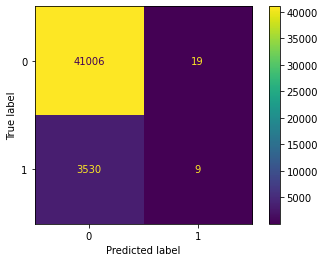

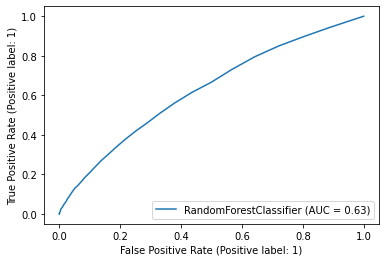

In [231]:
#import necessary packages 
import warnings 
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

#divide data into training and validation
X=df.drop(columns=['readmitted'])
y=df['readmitted']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.8,random_state=42)

#define and fit model
clf_forest=RandomForestClassifier()
clf_forest.fit(X_train, y_train)
y_pred=clf_forest.predict(X_test)
y_true=y_test

#gather and print scores 
accuracy=clf_forest.score(X_test,y_test)
scores_micro=precision_recall_fscore_support(y_true,y_pred,average='micro')
scores_weighted=precision_recall_fscore_support(y_true,y_pred,average='weighted')
print("accuracy: "+str(accuracy))
print("precision_micro: "+str(scores_micro[0]))
print("recall_micro: "+str(scores_micro[1]))
print("fscore_micro: "+str(scores_micro[2]))
print("precision_weighted: "+str(scores_weighted[0]))
print("recall_weighted: "+str(scores_weighted[1]))
print("fscore_weighted: "+str(scores_weighted[2]))

#plot confusion matrix
warnings.filterwarnings(action='ignore', category=FutureWarning)
plot_confusion_matrix(clf_forest, X_test, y_test)  
plt.show()

#plot roc curve with AUC listed
RocCurveDisplay.from_estimator(clf_forest, X_test, y_test)
plt.show()


## Test Set Evaluation and Final Model Selection

accuracy: 0.901624384011681
precision_micro: 0.901624384011681
recall_micro: 0.901624384011681
fscore_micro: 0.9016243840116809
precision_weighted: 0.8129265298444431
recall_weighted: 0.901624384011681
fscore_weighted: 0.8549811799630873


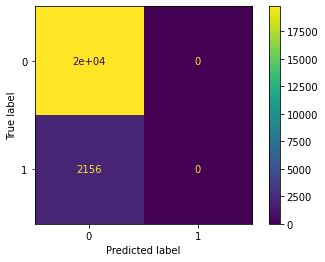

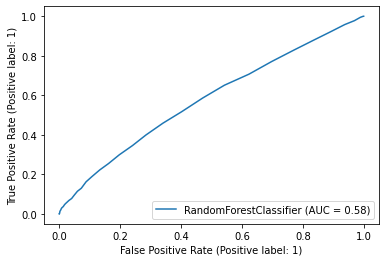

In [246]:
#Import test set and run through preprocessing

#import training data and delete weight, payer code, and gender
df=pd.read_csv("diabetic_data_test.csv").drop(columns=['weight','gender','payer_code'])

#import and sort id_codes for admssion type, discharge disposition, and admission source 

dfid=pd.read_csv("IDs_mapping.csv")
df_admissionTypeID = dfid.iloc[0:8]
df_dischargeID=dfid.iloc[10:40].reset_index(drop=True)
df_dischargeID.columns=['discharge_disposition_id', "description"]
df_dischargeID.dropna(inplace=True)
df_admissionSourceID=dfid.iloc[42:].reset_index(drop=True)
df_admissionSourceID.columns=['admission_source_id', "description"]

#ensure only one encounter per patient by only using the first encounter listed

df=df.drop_duplicates(subset=['patient_nbr'],keep='first').reset_index(drop=True)

#remove all encounters occurring in discharge to hospice or death

df=df[df['discharge_disposition_id'] != 11]
df=df[df['discharge_disposition_id'] != 13]
df=df[df['discharge_disposition_id'] != 14]
df=df[df['discharge_disposition_id'] != 19]
df=df[df['discharge_disposition_id'] != 20]
df=df[df['discharge_disposition_id'] != 21]

#now change HbA1C into a binary variable 1 = received testing, 0 = did not receive testing

df['A1Cresult'] = df['A1Cresult'].replace({'None':0, '>8':1,'Norm':1, '>7': 1})

#Cut medical_specialty
df=df.drop(columns=['Unnamed: 0', 'medical_specialty'])
#drop all specific medication features
df=df.drop(columns=['metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone'])
#drop encounter id and patient number 
df=df.drop(columns=['encounter_id','patient_nbr'])
#change race ? to Unknown and 1 hot encode listed variables
df['race'] = df['race'].replace({'?':"Unknown"})
df=pd.get_dummies(df,columns=['race','age','admission_type_id','discharge_disposition_id','admission_source_id'])
#drop the three diagnosis columns 
df=df.drop(columns=['diag_1','diag_2','diag_3'])
#change the max_glu_serum column to 0 1
df['max_glu_serum'] = df['max_glu_serum'].replace({'None':0,'Norm':1, '>200':1, '>300':1})
#change the change variable value ch to yes and 1 hot encode along with diabetesMed
df['change'] = df['change'].replace({'Ch':'Yes'})
df=pd.get_dummies(df,columns=['change','diabetesMed'])
#Change readmitted to 0 1
df['readmitted'] = df['readmitted'].replace({'NO':0,'>30':0, '<30':1})
#add blank feature columns for several discharge disposition and admission source because models were trained on 
#more features
df['discharge_disposition_id_12']=0
df['discharge_disposition_id_27']=0
df['admission_source_id_10']=0
df['admission_source_id_11']=0
df['admission_source_id_13']=0
df['admission_source_id_14']=0

#gather and print scores 
import warnings
warnings.filterwarnings('ignore')
X=df.drop(columns=['readmitted'])
y_true=df['readmitted']
y_pred=clf_forest.predict(X)
accuracy=clf_forest.score(X,y_true)
scores_micro=precision_recall_fscore_support(y_true,y_pred,average='micro')
scores_weighted=precision_recall_fscore_support(y_true,y_pred,average='weighted')
print("accuracy: "+str(accuracy))
print("precision_micro: "+str(scores_micro[0]))
print("recall_micro: "+str(scores_micro[1]))
print("fscore_micro: "+str(scores_micro[2]))
print("precision_weighted: "+str(scores_weighted[0]))
print("recall_weighted: "+str(scores_weighted[1]))
print("fscore_weighted: "+str(scores_weighted[2]))

#plot confusion matrix
warnings.filterwarnings(action='ignore', category=FutureWarning)
plot_confusion_matrix(clf_forest, X, y_true)  
plt.show()

#plot roc curve with AUC listed
RocCurveDisplay.from_estimator(clf_forest, X, y_true)
plt.show()

## Conclusion